# Objective Functions

* https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions

| Loss | Minimizer | Example |
|:-----|:----------|:--------|
| MSE, MAE, RMSLE  | Expectation (mean) | Regression (Expected return on stock) |
| Logistic, Entropy, KL-Divergence | Probability | Classification (Probability of click on ad) |
| Hinge | 0 ~ 1 approximation | Classification (Is the digit a 7?) |
| Poisson | Counts (Log Mean) | Regression (Number of call events to call center) |

In [1]:
%pylab inline
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import minmax_scale
from scipy import stats
from scipy.spatial.distance import cosine as cosine_distantce

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

Populating the interactive namespace from numpy and matplotlib


In [2]:
def display_graph(func, dfunc=None, name='loss', start=-2, end=2, y=[-2, -1, 0, 1, 2]):
    y = np.array(y)
    preds = np.arange(start, end + 0.001, 0.001)
    preds[preds == 0] = 1e-18
    
    fig, plots = plt.subplots(len(y))
    fig.set_tight_layout(True)
    fig.set_figheight(12)
    fig.set_figwidth(6)
    
    for plot, _y in zip(plots, y):
        _y = np.array([_y])
        r1 = [func(_y, np.array([p])) if p != 0 else 1e-18 for p in preds]
        if dfunc is not None:
            r2 = [dfunc(_y, np.array([p])) if p != 0 else 1e-18 for p in preds]

        plot.set_title(name + f' y={_y[0]}')
        plot.set_xlabel(f'prediction value {start} ~ {end}')
        plot.set_ylabel(f'{name} value')
        plot.plot(preds, r1, label=f'{name}')
        if dfunc is not None:
            plot.plot(preds, r2, label=f'derivative of {name}')
        plot.legend()
        plot.grid()

# Preparation

## Data

In [3]:
from sklearn.datasets import load_iris

In [4]:
np.random.seed(0)

# Load Dataset
iris = load_iris()
data_x = iris.data 
data_y = iris.target

# Shuffle
rand_indices = np.random.permutation(len(data_x))
data_x = data_x[rand_indices]
data_y = data_y[rand_indices]

print('data_x:', data_x.shape)
print('data_y:', data_y.shape)

data_x: (150, 4)
data_y: (150,)


## Model

정말 간단하게 linear model을 사용합니다.

In [5]:
np.random.seed(0)
w = np.random.rand(5)
w[0] = 1

def model(data_x):
    return data_x @ w[1:] + w[0]

# Mean Squared Error (MSE)

* http://mccormickml.com/2014/03/04/gradient-descent-derivation/

regression에서 대체로 많이 사용되는 cost function중의 하나입니다.<br>
장점이자 단점은 square 를 사용하기 때문에 cost이 지나치게 커져서 unstable 한 모델에 적용시 oscillation 현상이 일어날수 있으며, 잘 이용하면, cost값이 크게 나올경우 마찬가지로 큰 값으로 derivation해 줄수 있습니다. 

> Backpropagation 마지막단 레이어를 업데이트 시킬때 공식자체가 loss값으로 나온 값을 사용합니다.<br>
> 따라서 mse의 loss값이 크게 나온다는 뜻은 backpropagation에도 크게 영향을 미친다는 뜻입니다.

$$ J(\theta) = \frac{1}{N} \sum^{N}_{i=1} \left( y^{(i)} - h_{\theta}(x^{(i)})   \right)^2 $$

* $ J $ : cost function
* $ \theta $ : parameters (weights)
* N : training data의 갯수
* $ x^{(i)} $ : $ i^{th} $의 training input vector
* $ y^{(i)} $ : $ i^{th} $의 class label
* $ h_{\theta} \left( x^{(i)} \right) $ : $ \theta $를 사용하여 나온 $ i^{th} $ data에 대한 prediction


## Derivative of MSE

### Partial derivative of the weights

$$ \begin{eqnarray} \\
\frac{\partial}{\partial\theta} J(\theta) &=& \frac{\partial}{\partial \theta} \left( \frac{1}{N} \sum^N_{i=1} \left( y^{(i)} - h_{\theta}(x^{(i)}) \right)^2 \right) & [1] \\
&=&  \frac{2}{N} \sum^{N}_{i=0} \left( y^{(i)} - h_{\theta} (x^{(i)}) \right) \frac{\partial}{\partial \theta} \left( y^{(i)} - h_{\theta}(x^{(i)})  \right) & [2] \\
&=& \frac{2}{N} \sum^{N}_{i=0} \left(  y^{(i)} - h_{\theta} (x^{(i)}) \right) \frac{\partial}{\partial \theta} \left( y^{(i)} - \left(\theta^T \cdot x^{(i)} + b \right)  \right) & [3]\\
&=&  \frac{2}{N} \sum^{N}_{i=0} \left( y^{(i)} - h_{\theta} (x^{(i)}) \right) \odot - x^{(i)} & [4]\\
&=&  - \frac{2}{N} \sum^{N}_{i=0} \left( y^{(i)} - h_{\theta} (x^{(i)}) \right) \odot  x^{(i)} & [5]\\
\end{eqnarray} $$ 

* [3]: $ b, y$ 는 상수값으로서 0이 되고, $ \theta $ 는 그냥 1값이 됩니다.
* [5]: Deep Learning의 output layer에서 $ \odot $ 기준으로 왼쪽부분이 그대로 사용됩니다.<br>즉 MSE의 결과물로 나온 loss값이 사용되고, 이는 backpropagation에도 영향을 미치게 됩니다. <br>loss값이 큰 값이 나오면 크게 영향을 주고, 작게 나오면 작게 영향을 주게 됩니다.

### Partial derivative of the bias variable

$$ \begin{eqnarray} \\
\frac{\partial}{\partial b} J(\theta) &=& \frac{\partial}{\partial b} \left( \frac{1}{N} \sum^N_{i=1} \left( y^{(i)} - h_{\theta}(x^{(i)})  \right)^2 \right) & [1] \\
&=&  \frac{2}{N} \sum^{N}_{i=0} \left( y^{(i)} - h_{\theta} (x^{(i)}) \right) \frac{\partial}{\partial b} \left( y^{(i)} - h_{\theta}(x^{(i)})  \right) & [2] \\
&=& \frac{2}{N} \sum^{N}_{i=0} \left( y^{(i)} - h_{\theta} (x^{(i)}) \right) \frac{\partial}{\partial b} \left( y^{(i)} - \left( \theta^T \cdot x^{(i)} + b \right) \right) & [3]\\
&=& - \frac{2}{N} \sum^{N}_{i=0} \left( y^{(i)} - h_{\theta} (x^{(i)}) \right) & [4]\\
\end{eqnarray} $$ 


## MSE Code

### My MSE


In [6]:
def mean_squared_error(y_true, y_pred):
    return ((y_true - y_pred)**2).mean()

def derivative_mean_squared_error(y_true, y_pred):
    N = y_true.shape[0]
    return 2 * -np.mean(y_true - y_pred) 
    
mean_squared_error(data_y, model(data_x))

74.67315505565294

### Scipy MSE

In [7]:
metrics.mean_squared_error(data_y, model(data_x))

74.67315505565294

### Visualize MSE

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


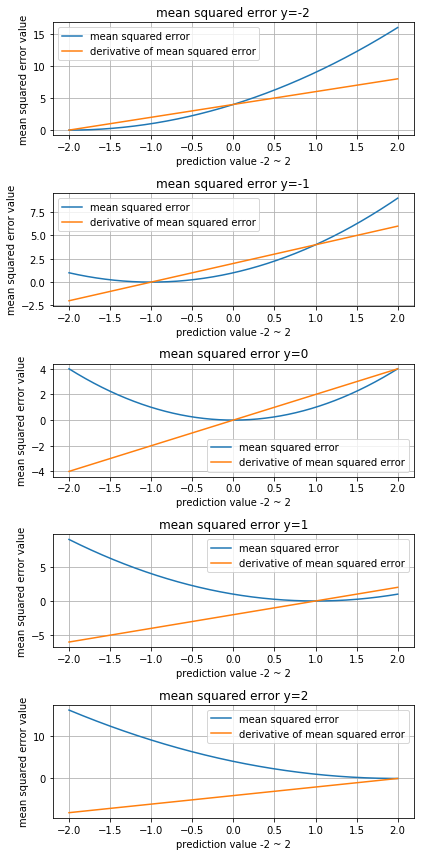

In [8]:
def display_graph(func, dfunc=None, name='loss', start=-2, end=2, y=[-2, -1, 0, 1, 2]):
    y = np.array(y)
    preds = np.arange(start, end + 0.001, 0.001)
    preds[preds == 0] = 1e-18
    
    fig, plots = plt.subplots(len(y))
    fig.set_tight_layout(True)
    fig.set_figheight(12)
    fig.set_figwidth(6)
    
    for plot, _y in zip(plots, y):
        _y = np.array([_y])
        r1 = [func(_y, np.array([p])) if p != 0 else 1e-18 for p in preds]
        if dfunc is not None:
            r2 = [dfunc(_y, np.array([p])) if p != 0 else 1e-18 for p in preds]

        plot.set_title(name + f' y={_y[0]}')
        plot.set_xlabel(f'prediction value {start} ~ {end}')
        plot.set_ylabel(f'{name} value')
        plot.plot(preds, r1, label=f'{name}')
        if dfunc is not None:
            plot.plot(preds, r2, label=f'derivative of {name}')
        plot.legend()
        plot.grid()

display_graph(metrics.mean_squared_error, 
              derivative_mean_squared_error, 
              'mean squared error')

# Mean Absolute Error (MAE)

MSE가 large error를 낸다면, MAE의 경우는 상대적으로 작은 에러들을 만듭니다.<br>
하지만 수학적으로 absolute는 많은 연산량을 필요로 합니다. 

$$ J(\theta) = \frac{1}{N} \sum^{N}_{i=1} \left| y^{(i)} - h_{\theta}(x^{(i)}) \right| $$


## Derivative of MAE

### Partial derivative of the weights

> $ \frac{d}{dx} |u(x)| = \frac{u(x)}{|u(x)|} \cdot \frac{d}{dx} u(x) $

$$ \begin{align} 
\frac{\partial}{\partial \theta} J(\theta) &= \frac{\partial}{\partial \theta} \left( \frac{1}{N} \sum^{N}_{i=1} \left| y^{(i)} - h_{\theta}(x^{(i)})  \right| \right) \\
&= \frac{1}{N} \sum^{N}_{i=1} \frac{\partial}{\partial \theta} \left( \left| y^{(i)} - h_{\theta}(x^{(i)})  \right| \right) \\
&= \frac{1}{N} \sum^{N}_{i=1}  \frac{ y^{(i)} - h_{\theta}(x^{(i)}) }{\left| y^{(i)} -  h_{\theta}(x^{(i)})  \right|} \odot \frac{\partial}{\partial \theta} \left[ y^{(i)} - \left( \theta^T \cdot x^{(i)} + b  \right) \right] \\
&= \frac{1}{N} \sum^{N}_{i=1}  \frac{ y^{(i)} - h_{\theta}(x^{(i)}) }{\left| y^{(i)} -  h_{\theta}(x^{(i)})  \right|} \odot - x^{(i)} \\
&= - \frac{1}{N} \sum^{N}_{i=1}  \frac{ y^{(i)} - h_{\theta}(x^{(i)}) }{\left| y^{(i)} -  h_{\theta}(x^{(i)})  \right|} \odot  x^{(i)}
\end{align}$$

분모 부분에 0이 나오면 안되므로, Mean Absolute Error는 $ y_{\text{true}} = y_{\text{pred}} $ 일때 differentiable하지 않습니다.<br>
또한 분모와 분자가 같은 값을 갖으므로 (plus 또는 minus sign을 제외하고 봤을때.. ) 결론적으로 다음과 같이 됩니다.

$$ 
\dfrac{d\text{MAE}}{dy_{\text{pred}}} = 
\begin{cases}
  +x^{(i)},\quad y_{\text{true}}>y_{\text{pred}}\\
  -x^{(i)},\quad y_{\text{true}}<y_{\text{pred}}
\end{cases} $$

### Partial derivative of the bias

$$ \begin{align} 
\frac{\partial}{\partial \theta} J(\theta) = - \frac{1}{N} \sum^{N}_{i=1}  \frac{ y^{(i)} - h_{\theta}(x^{(i)}) }{\left| y^{(i)} -  h_{\theta}(x^{(i)})  \right|} 
\end{align}$$

마찬가지로, 분모와 분자가 같은 값을 갖으므로 (plus 또는 minus sign을 제외하고 봤을때..) 결론적으로 다음과 같습니다.

$$ 
\dfrac{d\text{MAE}}{dy_{\text{pred}}} = 
\begin{cases}
  +1,\quad y_{\text{true}}>y_{\text{pred}}\\
  -1,\quad y_{\text{true}}<y_{\text{pred}}
\end{cases} $$

## MAE Code

### My MAE

In [81]:
def mean_abolute_error(y_true, y_pred):
    return np.abs(y_true-y_pred).mean()

def derivative_mean_absolute_error(y_true, y_pred):
    return np.mean((y_true - y_pred)/np.abs((y_true - y_pred)))

mean_abolute_error(data_y, model(data_x))

8.575784357990875

### Scipy MAE

In [82]:
metrics.mean_absolute_error(data_y, model(data_x))

8.575784357990875

### Visualize MAE

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


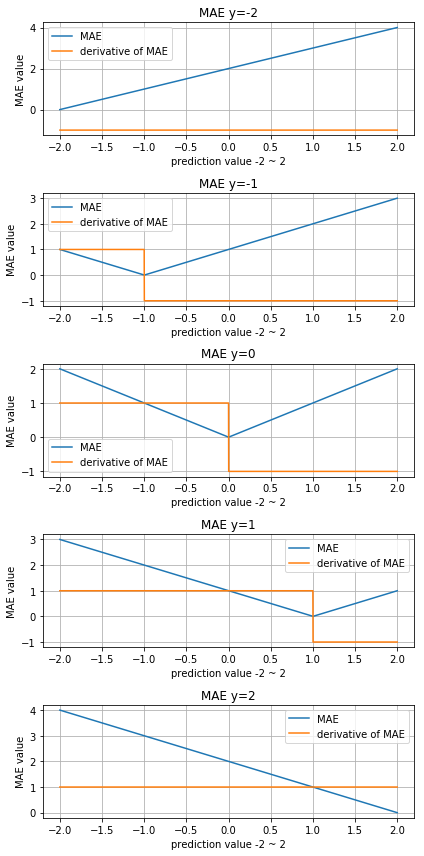

In [83]:
display_graph(metrics.mean_absolute_error, derivative_mean_absolute_error, 'MAE')

## Root Mean Squared Logarithmic Error (RMSLE)

$ p $ 그리고 $ a $ 는 확률.. 즉 0에서 1사이이의 값이 들어가야 합니다.

$$ \epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

In [90]:
def mean_squared_logarithmic_error(y, p):
    try:
        l = lambda x: np.nan_to_num(np.log(x + 1))
        return np.sqrt(((l(p) - l(y))**2).mean())
    except Exception as e:
        print(p + 1)
        raise e

mean_squared_logarithmic_error(data_y, model(data_x))

1.7744189154188452

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


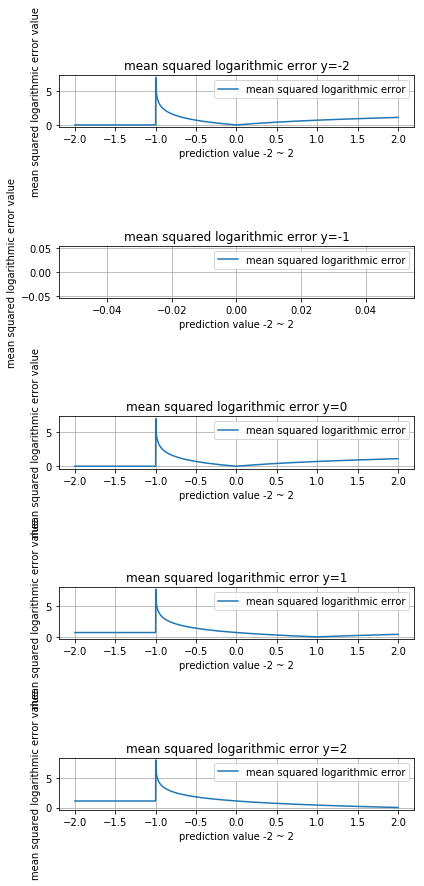

In [88]:
display_graph(mean_squared_logarithmic_error, name='mean squared logarithmic error')

## Binary Cross Entropy (a.k.a Logarithmic Loss)

* https://www.kaggle.com/wiki/LogarithmicLoss

$$ \text{logloss} = -\frac{1}{N} \sum^{N}_{i=1} \left( y^{(i)} \cdot \log(p_i) + (1 - y) \cdot \log(1- p_i) )  \right) $$



#### Numpy

In [15]:
y_true = np.array([0, 0, 0, 1, 0], dtype=np.float64)
y_pred = np.array([0.1, 0.1, 0.05, 0.6, 0.3], dtype=np.float64)

def binary_cross_entropy(y_true, y_pred):
    return -(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred)).mean()

binary_cross_entropy(y_true, y_pred)

0.22590297868158524

#### Scipy

In [16]:
# Scipy와 동일함
metrics.log_loss(y_true, y_pred)

0.22590297868158524

#### Pytorch

F.binary_cross_entropy 와 nn.BCELoss 의 결과값은 동일합니다.

In [17]:
y_torch_pred = Variable(torch.DoubleTensor(y_pred))
y_torch_true = Variable(torch.DoubleTensor(y_true))

torch_crossentropy = nn.BCELoss()
torch_crossentropy(y_torch_pred, y_torch_true).data.numpy()

array([ 0.22590298])

#### Display

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


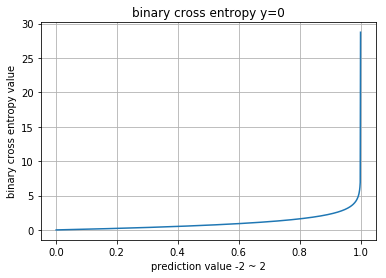

In [18]:
display_graph(binary_cross_entropy, 'binary cross entropy')

## Cross Entropy

* https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/

$$ H(y, \hat{y}) = - \sum_i y^{(i)} \log \hat{y}^{(i)} $$

#### Partial derivative of the weights

$$ \begin{eqnarray}
H(y, \hat{y}) &=& -\frac{\partial}{\partial \theta} \sum^N_{i=1} y^{(i)} \log \hat{y}^{(i)} \\
&=& - \sum^N_{i=1} \frac{y^{(i)}}{ \frac{\partial}{\partial \theta} \hat{y}^{(i)}} \\
&=& - \sum^N_{i=1} \frac{y^{(i)}}{ \frac{\partial}{\partial \theta} \left( \theta^{T} \cdot x^{(i)} + b \right) } \\
&=& - \sum^N_{i=1} \frac{y^{(i)}}{x^{(i)}}
\end{eqnarray} $$

#### Partial derivative of the bias 

$$ \begin{eqnarray}
H(y, \hat{y}) &=& -\frac{\partial}{\partial b} \sum^N_{i=1} y^{(i)} \log \hat{y}^{(i)} \\
&=& - \sum^N_{i=1} \frac{y^{(i)}}{ \frac{\partial}{\partial b} \hat{y}^{(i)}} \\
&=& - \sum^N_{i=1} \frac{y^{(i)}}{ \frac{\partial}{\partial b} \left( \theta^{T} \cdot x^{(i)} + b \right) } \\
&=& - \sum^N_{i=1} y^{(i)}
\end{eqnarray} $$

#### Numpy

In [19]:
y_true = np.array([0, 0, 0, 1, 0], dtype=np.float32)
y_pred = np.array([0.1, 0.1, 0.05, 0.6, 0.3], dtype=np.float32)

def cross_entropy(y_true, y_pred):
    return -(y_true * np.log(y_pred)).sum()

cross_entropy(y_true, y_pred)

0.51082557

#### Pytorch - cross entropy

Pytorch의 cross entropy는 일반적인 cross entropy와 전혀 다릅니다.

$$ \hat{y}_{class} + \log\left( \sum_j e^{\hat{y}_j} \right) $$

In [20]:
y_true = np.array([3, 1], dtype=np.int64)
y_pred = np.array([[0.1, 0.1, 0.05, 0.6, 0.3], 
                   [0, 0.9, 0.05, 0.001, 0.3]], dtype=np.float64)


def torch_cross_entropy(y_pred, labels):
    N = y_pred.shape[0]
    return (-y_pred[range(N), labels] + np.log(np.sum(np.exp(y_pred), axis=1))).mean()
    
torch_cross_entropy(y_pred, y_true)

1.1437464478328658

In [21]:
y_true = np.array([3], dtype=np.int64)
y_pred = np.array([[0.1, 0.1, 0.05, 0.6, 0.3]], dtype=np.float32)

def torch_cross_entropy(y_pred, labels):
    N = y_pred.shape[0]
    return (-y_pred[range(N), labels] + np.log(np.sum(np.exp(y_pred), axis=1))).mean()
    

torch_cross_entropy(y_pred, y_true)

1.2615328

In [22]:
y_true = np.array([3], dtype=np.int64)
y_pred = np.array([[0.1, 0.1, 0.05, 0.6, 0.3]], dtype=np.float32)

y_torch_true = Variable(torch.LongTensor(y_true))
y_torch_pred = Variable(torch.FloatTensor(y_pred))

torch_cross_entropy = nn.CrossEntropyLoss()
torch_cross_entropy(y_torch_pred, y_torch_true).data.numpy()

array([ 1.26153278], dtype=float32)

#### Pytorch - Custom Cross Entropy

Pytorch에서 제공하는 nn.CrossEntropyLoss는 기존 cross-entropy loss와 다름으로, 정확하게 동일한 코드를 사용시 만들어줘야 합니다.

In [23]:
def torch_custom_cross_entropy(y_true, y_pred):
    return -torch.sum(y_true * torch.log(y_pred))
    
y_true = np.array([0, 0, 0, 1, 0], dtype=np.float32)
y_pred = np.array([0.1, 0.1, 0.05, 0.6, 0.3], dtype=np.float32)

y_torch_true = Variable(torch.FloatTensor(y_true))
y_torch_pred = Variable(torch.FloatTensor(y_pred))

torch_custom_cross_entropy(y_torch_true, y_torch_pred).data.numpy()

array([ 0.51082557], dtype=float32)

#### Display

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


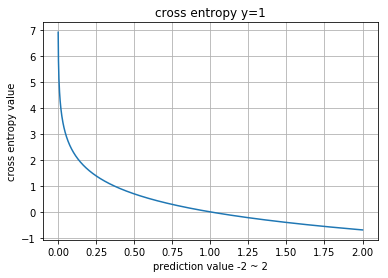

In [24]:
display_graph(cross_entropy, 'cross entropy', y=1)

## Hinge Loss

logistic과 마찬가지로 binary classification에 사용됩니다.<br>
라이브러리 사용하면 알아서 처리되지만, 기본적으로 labels은 -1 또는 1이어야 합니다. 

Hinge loss는 softmax처럼 확률을 계산하는 것이 아니라 maximum-margin 을 계산하기 때문에 SVM에 사용됩니다.<br>
따라서 딥러닝분야에서는 hinge loss보다는 softmax같은 것을 더 많이 사용합니다.

$$ J(\theta) = max(0,\ 1 - y * f(x)) $$

In [25]:
p = np.array([0.1, 0.1, 0.05, 0.6, 0.3], dtype=np.float32)
y = np.array([-1, -1, -1, 1, -1], dtype=np.float32)

def hinge_loss(y, p):
    l = 1-(y*p)
    l[l<=0] = 0
    return l.mean()

hinge_loss(y, p)

0.98999995

In [26]:
metrics.hinge_loss(y, p)

0.98999999836087227

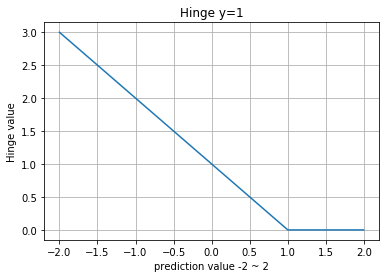

In [27]:
display_graph(hinge_loss, 'Hinge', y=1)

## KL-Divergence

$ p $ 그리고 $ q $ 는 확률분포 (0에서 1사이의 값) 이어야 합니다.

$$ D_{KL}\left(p(x), q(x)\right) = \sum_{x \in X} p(x) \ln\frac{p(x)}{q(x)} $$

> 참고로.. Scipy.stats.entropy(a, b)를 사용하면 KL-Divergence를 사용하는 것과 마찬가지인데.. <br>
> 내부적으로 nan등 처리가 안되어 있어서 값이 안나옴

In [28]:
def kl_divergence(y, p):
    return np.sum(y * np.nan_to_num(np.log(y/p)), axis=0)

compare_distributions(kl_divergence)

normal_a, normal_a	: 0.0
normal_a, normal_b	: 366.100361677
normal_a, gumbel  	: 2861.7048281
normal_a, exponent	: 5382.51009594
normal_a, uniform 	: 6428.79914273


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


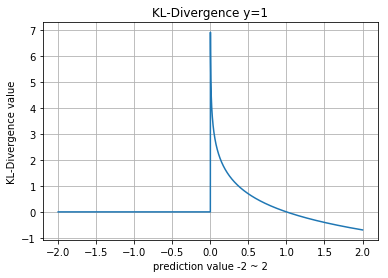

In [29]:
display_graph(kl_divergence, 'KL-Divergence', y=1)

## Cosine Proximity

* https://en.wikipedia.org/wiki/Cosine_similarity

기본적으로 2개의 vectors 사이의 cos각도를 알아냄으로서 두 vectors사이의 차이를 계산합니다.

$$ \text{similarity} = cos(\theta) = \frac{A \cdot B}{ \| A \|_2 \| B \|_2}  $$

In [30]:
def cosine_proximity(a, b):
    norm2 = lambda x: np.sqrt((x**2).sum())
    return 1 - (a * b).sum() / (norm2(a) * norm2(b))

cosine_proximity(np.array([0.3, 0.4]), np.array([1, 2]))

0.016130089900092459

In [31]:
compare_distributions(cosine_distantce)

normal_a, normal_a	: 0.0
normal_a, normal_b	: 0.0934316854405
normal_a, gumbel  	: 0.583817708551
normal_a, exponent	: 0.343064016073
normal_a, uniform 	: 0.173656927432


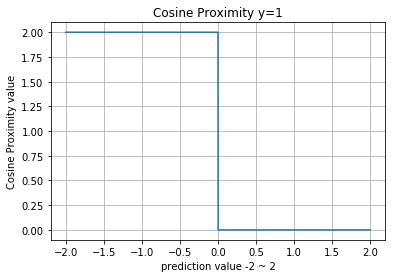

In [32]:
display_graph(cosine_proximity, 'Cosine Proximity', y=1)

## Poisson

* https://github.com/fchollet/keras/pull/479/commits/149d0e8d1871a7864fc2d582d6ce650512de371c

In [33]:
p = np.array([0.1, 0.1, 0.05, 0.6, 0.3], dtype=np.float32)
y = np.array([0, 0, 0, 1, 0], dtype=np.float32)

def poisson_loss(y, p):
    return (p - y * np.log(p)).mean()

poisson_loss(y, p)

0.33216509

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


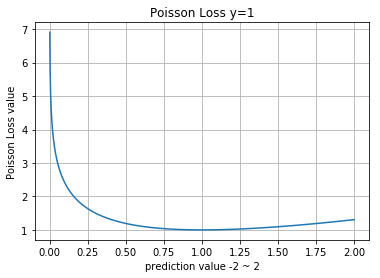

In [34]:
display_graph(poisson_loss, 'Poisson Loss', y=1)